In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from nbodykit.lab import cosmology

import plotter

In [2]:
cosmo_base = cosmology.Planck15

In [3]:
dict(cosmo_base)

{'output': 'vTk dTk mPk',
 'extra metric transfer functions': 'y',
 'h': 0.6774,
 'N_ur': 2.0328,
 'gauge': 'synchronous',
 'n_s': 0.9667,
 'ln10^{10}A_s': 3.064,
 'k_pivot': 0.05,
 'tau_reio': 0.066,
 'T_cmb': 2.7255,
 'Omega_cdm': 0.2589,
 'Omega_b': 0.0486,
 'Omega_k': 0.0,
 'N_ncdm': 1,
 'm_ncdm': [0.06],
 'P_k_max_h/Mpc': 10.0,
 'z_max_pk': 100.0}

In [4]:
params = ['Omega_cdm', 'Omega_b', 'h']
# colors
nds = len(params)
color_idx = np.linspace(0, 1, nds)
colors = []
for i in range(nds):
    color=plt.cm.rainbow(color_idx[i])
    colors.append(color)   

In [6]:
redshift = 0

smin = 1
smax = 150
s = np.linspace(smin, smax, 300)

In [7]:
Plin = cosmology.LinearPower(cosmo_base, redshift, transfer='EisensteinHu')
CF = cosmology.correlation.CorrelationFunction(Plin)
xi_base = CF(s)

In [50]:
cosmo_derivs = []
ds = []
for param in params:
    cosmo_dict = dict(cosmo_base)
    val_base = cosmo_dict[param]
    dval = val_base * 0.01
    ds.append(dval)
    val_new = val_base + dval
    cosmo_dict[param] = val_new
    cosmo_derivs.append(cosmology.Cosmology.from_dict(cosmo_dict))

In [51]:
xis = []
for i in range(len(cosmo_derivs)):
    cosmo = cosmo_derivs[i]
    Plin = cosmology.LinearPower(cosmo, redshift, transfer='EisensteinHu')
    CF = cosmology.correlation.CorrelationFunction(Plin)
    xis.append(CF(s))

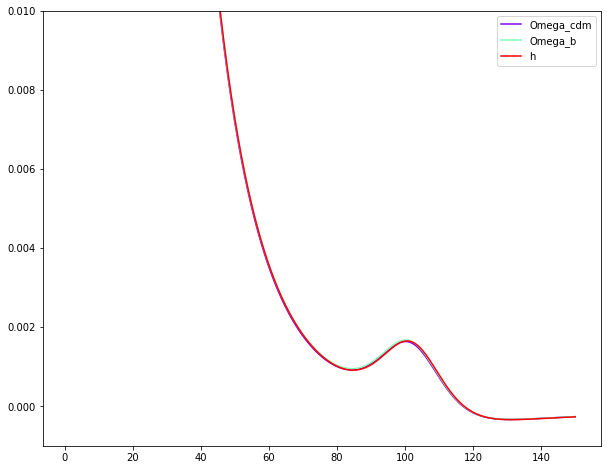

In [52]:
plt.figure(figsize=(10,8))
for i in range(len(cosmo_derivs)):
    plt.plot(s, xis[i], label=params[i], color=colors[i])

#plt.xscale('log')
#plt.yscale('log')
plt.ylim((-0.001, 0.01))

plt.legend()

In [62]:
def partial_derivative(f1, f2, dv):
    df = f2-f1
    deriv = df/dv
    return deriv

In [54]:
dcosmos = []
for i in range(len(params)):
    xi = xis[i]
    dcosmos.append(partial_derivative(xi_base, xi, ds[i]))

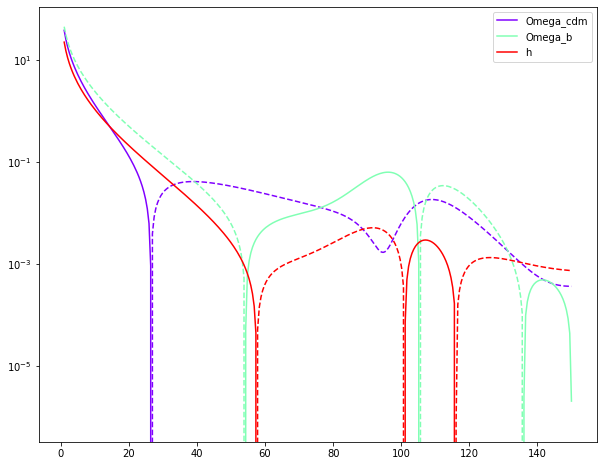

In [74]:
plt.figure(figsize=(10,8))
for i in range(len(cosmo_derivs)):
    plt.plot(s, dcosmos[i], label=params[i], color=colors[i])
    plt.plot(s, -dcosmos[i], ls='--', color=colors[i])

plt.yscale('log')
plt.legend()

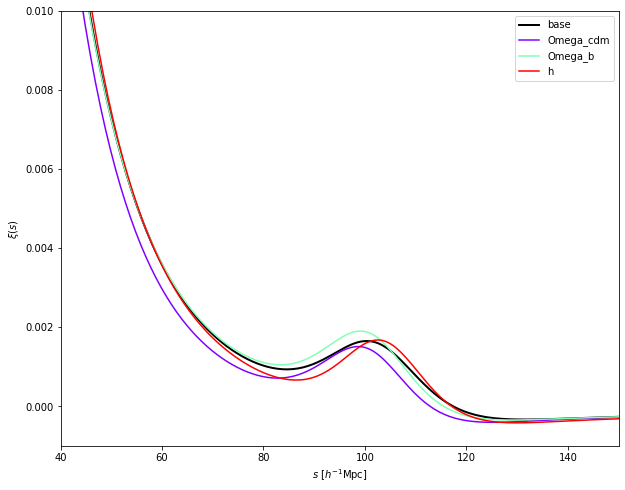

In [64]:
# TODO: h is different than when using astropy (dcosmo.ipynb), investigate

plt.figure(figsize=(10,8))
plt.plot(s, xi_base, ls='-', label='base', color='black', lw=2)
# 10% change
for i in range(nds):
    plt.plot(s, xi_base+10*ds[i]*dcosmos[i], color=colors[i], label=params[i])
    
plt.ylim((-0.001, 0.01))
plt.xlim((0, 200))
#plt.ylim([10**-3, 10**0])

plt.xlabel(r'$s$ $[h^{-1} \mathrm{Mpc}]$')
plt.ylabel(r'$\xi(s)$')
plt.xlim(40,150)
plt.legend()

In [65]:
def gs(X):
    Q, R = np.linalg.qr(X)
    return Q

In [68]:
dcosmos = np.array(dcosmos)
print(dcosmos.shape)

(3, 300)


In [72]:
dcosmos_gs = gs(dcosmos.T).T
print(dcosmos_gs.shape)

(3, 300)


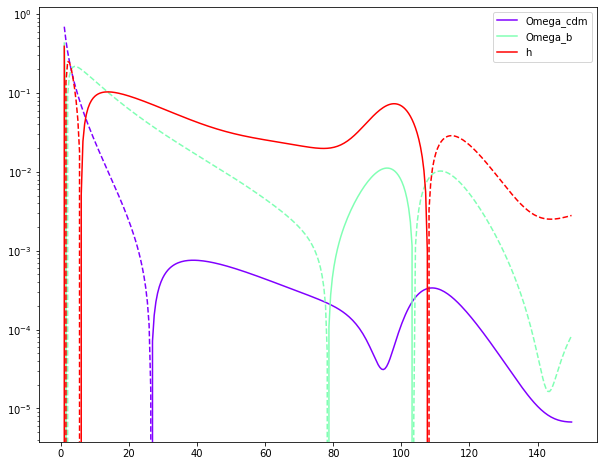

In [75]:
plt.figure(figsize=(10,8))
for i in range(len(cosmo_derivs)):
    plt.plot(s, dcosmos_gs[i], label=params[i], color=colors[i])
    plt.plot(s, -dcosmos_gs[i], ls='--', color=colors[i])

plt.yscale('log')
plt.legend()

In [98]:
def plot_lognormal(tag, cat_tag, proj_types, plot_tag=None, log=False):
    result_dir = '../results/results_lognormal{}'.format(cat_tag)
    cat_dir = '../catalogs/cats_lognormal{}'.format(cat_tag)
    
    r_stan_lin, xi_stan_lin, label_stan = np.load('{}/cf_lin_{}{}.npy'.format(result_dir, 'standard', tag), allow_pickle=True, encoding='latin1')
    rs_lin = [r_stan_lin]
    cfs_lin = [xi_stan_lin]
    if log:
        r_stan_log, xi_stan_log, label_stan = np.load('{}/cf_log_{}{}.npy'.format(result_dir, 'standard', tag), allow_pickle=True, encoding='latin1')
        rs_log = [r_stan_log]
        cfs_log = [xi_stan_log]

    for proj_type in proj_types:

        r_lin, xi_proj_lin, projt = np.load('{}/cf_lin_{}{}.npy'.format(result_dir, proj_type, tag), allow_pickle=True, encoding='latin1')
        rs_lin.append(r_lin)
        cfs_lin.append(xi_proj_lin)
        if log:
            r_log, xi_proj_log, projt = np.load('{}/cf_log_{}{}.npy'.format(result_dir, proj_type, tag), allow_pickle=True, encoding='latin1')
            rs_log.append(r_log)
            cfs_log.append(xi_proj_log)

    colors = [color_dict['standard']] + [color_dict[pt] for pt in proj_types]
    labels = ['standard'] + [label_dict[pt] for pt in proj_types]

    r_true_lin, xi_true_lin, label_true = np.load('{}/cf_lin_{}{}.npy'.format(cat_dir, 'true', cat_tag), allow_pickle=True, encoding='latin1')
    if plot_tag:
        save_lin = '{}/cf_lin{}{}.png'.format(plot_dir, tag, plot_tag)
    else:
        save_lin = None
    plotter.plot_cf_cont(rs_lin, cfs_lin, r_true_lin, xi_true_lin, labels, colors, saveto=save_lin, log=False, err=True)

    if log:
        r_true_log, xi_true_log, label_true = np.load('{}/cf_log_{}{}.npy'.format(cat_dir, 'true', cat_tag), allow_pickle=True, encoding='latin1')
        save_log = '{}/cf_log{}{}.png'.format(plot_dir, tag, plot_tag)
        plotter.plot_cf_cont(rs_log, cfs_log, r_true_log, xi_true_log, labels, colors, saveto=save_log, log=True, err=True)



In [112]:
plot_dir = '../plots/plots_2019-10-29'
result_dir = '../results/results_2019-10-28'
cat_dir = '../catalogs/catalogs_2019-10-28'
label_dict = {'generalr': 'cosmo deriv', 'tophat': 'tophat', 'piecewise':'triangle', 'linear_spline':'linear spline', 'quadratic_spline': 'quadratic spline', 'quadratic_spline_nbins8':'quadratic spline (8 bins)', 'dcosmo_test': 'dcosmo', 'generalr':'generalr'}
color_dict = {'tophat':'blue', 'standard': 'orange', 'piecewise':'crimson', 'linear_spline':'red', 'cosmo deriv':'purple', 'triangle':'crimson', 'quadratic_spline':'green', 'quadratic_spline_nbins8':'limegreen', 'dcosmo_test':'magenta', 'generalr':'grey'}

In [117]:
boxsize = 750
nbar_str = '3e-4'
#nbar_str = '1e-5'
cat_tag = '_L{}_nbar{}_py2'.format(boxsize, nbar_str)
seed = 0

plotting


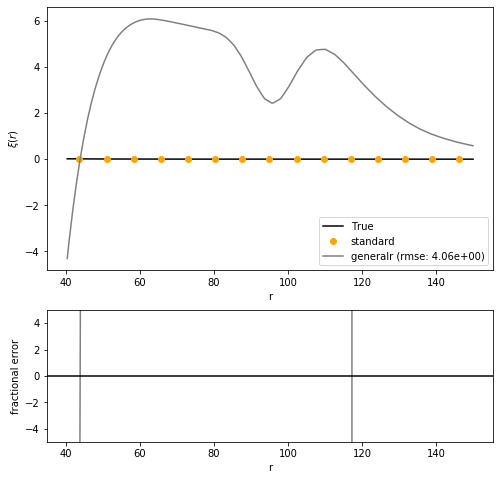

In [118]:
tag = cat_tag+'_seed{}'.format(seed)

proj_types = ['generalr']
plot_lognormal(tag, cat_tag, proj_types)